In [1]:
%matplotlib inline
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

###### This section of the code is used for testing

In [9]:
# Test Code
session.query(Measurement.date).limit(10).all()

[('2010-01-01'),
 ('2010-01-02'),
 ('2010-01-03'),
 ('2010-01-04'),
 ('2010-01-06'),
 ('2010-01-07'),
 ('2010-01-08'),
 ('2010-01-09'),
 ('2010-01-10'),
 ('2010-01-11')]

In [10]:
# test code
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# test code
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# test code
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


###### Test code section end

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).all()
most_recent_date

[('2017-08-23')]

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
previous_yr = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prec_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= previous_yr).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(prec_scores, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
prec_df = prec_df.sort_index()

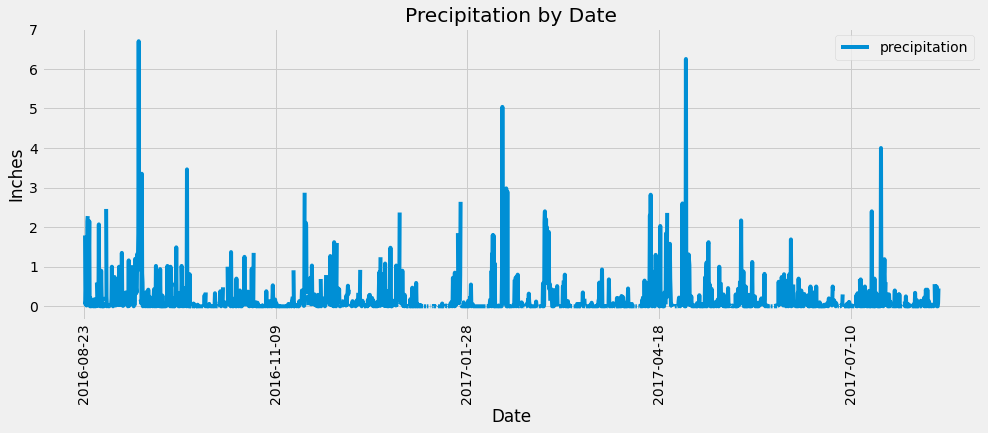

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(figsize=(15,5))

plt.title('Precipitation by Date')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation = 'vertical')

plt.savefig('Images/Precipitation_by_Date_bar.png')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [32]:
# Check if all the stations has some measuremnt
session.query(Measurement.station).distinct().count()

9

In [33]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_cnts = session.query(Measurement.station, func.count(Measurement.date))\
                                .group_by(Measurement.station)\
                                .order_by(desc(func.count(Measurement.date)))\
                                .all()

# Put the read data in to a dataframe                              
station_cnts_df = pd.DataFrame(station_cnts, columns=['station', 'count'])
station_cnts_df

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [35]:
# Get the most active station ID
act_station =  ', '.join(station_cnts_df.head(1)['station'])
print('Most active station ID is ' + act_station)

Most active station ID is USC00519281


In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
act_station_summary_vals = session.query(Measurement.station, func.min(Measurement.tobs),\
                                                                func.max(Measurement.tobs),\
                                                                func.avg(Measurement.tobs))\
                                             .filter(Measurement.station == act_station)\
                                             .all()

# Put the data in to a dataframe
act_station_summary_df = pd.DataFrame(act_station_summary_vals, columns=['most active station', 'min', 'max', 'average'])
act_station_summary_df

,most active station,min,max,average
0,USC00519281,54.0,85.0,71.663781


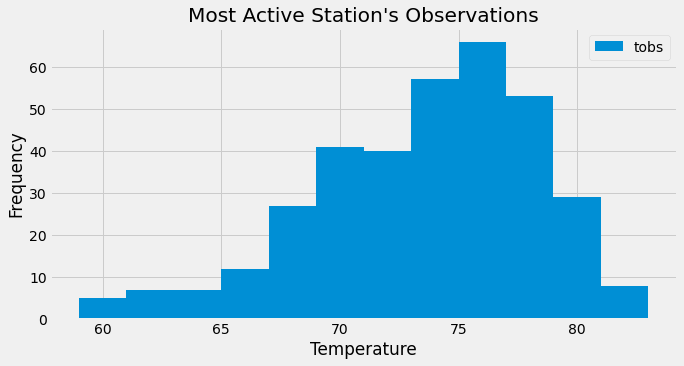

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the 12 month values
act_station_temperature = session.query(Measurement.date, func.strftime('%m', Measurement.date), Measurement.tobs)\
                            .filter(Measurement.date >= previous_yr)\
                            .filter(Measurement.station == act_station)\
                            .all()

# Put the data in to a dataframe
act_station_temperature_df = pd.DataFrame(act_station_temperature, columns=['date', 'month', 'tobs'])

# Plot the histogram 
act_station_temperature_df.plot(kind='hist', bins=12, figsize=(10,5))

# name the chart a title, x label, and y label
plt.title("Most Active Station's Observations")
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Save an image of the chart and print it to the screen
#plt.show()
plt.savefig('Images/Active_Station_Observations_hist.png')

# Close session

In [38]:
# Close Session
session.close()